# Credit Card Fraud Detection

In this project, we will address the issue of credit card fraud, one of the main concerns of financial institutions such as banks and *fintechs*. In Brazil, about 12.1 million people have been victims of some type of financial fraud in the last year. Translated into values, the financial blows surpassed the figure of BRL 1.8 billion in losses per year for the last 12 months.

Among these frauds, those involving credit cards are of great relevance since their non-detection will result in considerable losses, both for the consumer and for the financial institution.

Another factor to be considered is the amount of false positives, that is, those times when you tried to make a purchase and had your card preemptively blocked - which probably caused stress and embarrassment.

For all these reasons, the investment in the area of ​​fraud detection through Artificial Intelligence has been growing every year, representing a great opportunity in *Data Science*.

With large volumes of data as a historical basis, a machine learning algorithm just a little better than the previous ones already represents a savings of millions of Reais. And that is the challenge, to increasingly improve the use of algorithms aimed at inhibiting or preventing fraudulent transactions.

## Solution Proposal

To solve this problem, we will perform the following tasks:

- **0.0.** Data Colection
- **1.0.** Data Description
- **2.0.** Exploratory Data Analysis
- **3.0.** Data Preparation
- **4.0.** Machine Learning Modeling
- **9.0.** Translation and Interpretation of the Error
- **10.0.** Deploy Model to Production

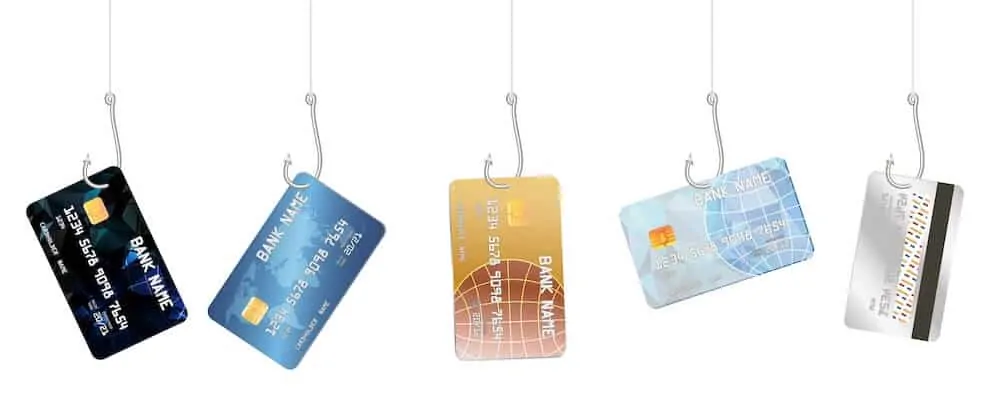

In [3]:
Image('img/card.jpg')

# 0.0. Imports

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import matplotlib.gridspec   as gridspec
import seaborn               as sns
import scikitplot            as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.svm             import SVC
from sklearn.naive_bayes     import GaussianNB
from sklearn.metrics         import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from IPython.display         import Image

## 0.1. Helper Functions

In this step, i'll documentation all of the functions that we will need to use in the next sections.

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def model_performance( y_test, y_pred ):
    skplt.metrics.plot_confusion_matrix( y_test, y_pred, normalize=True, figsize=(6, 6) )
    
    print( classification_report( y_test, y_pred, digits=4 ) )
    print('AUC: ', round( roc_auc_score( y_test, y_pred ), 4 ) )
    
def cross_validation( model, X_res, y_res ):
    accuracy = cross_val_score( model, X_res, y_res, cv=5, scoring='accuracy' )
    precision = cross_val_score( model, X_res, y_res, cv=5, scoring='precision' )
    recall = cross_val_score( model, X_res, y_res, cv=5, scoring='recall' )
    f1 = cross_val_score( model, X_res, y_res, cv=5, scoring='f1' )
    roc = cross_val_score( model, X_res, y_res, cv=5, scoring='roc_auc' )
    
    return pd.DataFrame( {'accuracy': np.round( np.mean( accuracy ), 2 ).astype( str ) + '+/-' + np.round( np.std( accuracy ), 2 ).astype( str ),
                          'precision': np.round( np.mean( precision ), 2 ).astype( str ) + '+/-' + np.round( np.std( precision ), 2 ).astype( str ),
                          'recall': np.round( np.mean( recall ), 2 ).astype( str ) + '+/-' + np.round( np.std( recall ), 2 ).astype( str ), 
                          'f1': np.round( np.mean( f1 ), 2 ).astype( str ) + '+/-' + np.round( np.std( f1 ), 2 ).astype( str ),
                          'roc': np.round( np.mean( roc ), 2 ).astype( str ) + '+/-' + np.round( np.std( roc ), 2 ).astype( str ) }, index = [0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

The data we will use in this project has been made available by some European credit card companies. The *dataset* represents the financial transactions that took place in the period of two days, where 492 frauds were classified among almost 290 thousand transactions.

An interesting detail is that the *features* are all numerical, and have been defaced (due to privacy and security issues). Thus, column names are represented by $[V1, V2, V3 \dots, V28]$.

<p align=center>
<img src="img/atm.jpg" width="50%"></p>

[On the original data page](https://www.kaggle.com/mlg-ulb/creditcardfraud) it is also reported that the variables have gone through a transformation known as Principal Component Analysis (*Principal Component Analysis* - PCA).

PCA allows for dimensionality reduction while maintaining as much information as possible. To achieve this, the algorithm finds a new set of features - called **components**.

These components are less than or equal to the original variables. In the case of this project, the components found by the PCA transformation are the columns $[V1, V2, V3 \dots, V28]$.

In addition, there are also three other columns, Time, Amount and Class. The Time column contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [4]:
# Loading data
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"
df_raw = pd.read_csv( file_path )

df_raw.sample()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
8009,10993.0,1.308139,-0.107937,0.162637,-0.191696,0.081348,0.489166,-0.549243,0.040426,1.559606,-0.359687,0.833469,-2.127339,2.237944,1.52448,-0.01773,1.178308,-0.597636,1.188706,0.533259,0.019325,-0.120407,-0.123271,-0.251762,-1.362802,0.412063,1.11868,-0.095771,-0.01972,24.95,0


# 1.0. Data Description

In this step, we will understand and analyze the data descriptively. To do this, we will perform the following tasks:

- Data Dimensions
- Data Types
- Check Missing Values
- Descriptive Statistical

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [9]:
print( 'Number of rows: ', df1.shape[0] )
print( 'Number of columns: ', df1.shape[1] )

Number of rows:  284807
Number of columns:  31


## 1.2. Data Types

In [10]:
df1.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

## 1.3. Check Missing Values

As we can see, there are no missing values in our dataset.

In [13]:
df1.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# 1.4. Descriptive Statistical

In this step we will use two types of analysis:

- Central Tendency
    - Average
    - Median
- Dispersion
    - standard deviation
    - min
    - max
    - range
    - skew
    - kurtosis

In [14]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( df1.apply( np.mean ) ).T
ct2 = pd.DataFrame( df1.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( df1.apply( np.std ) ).T
d2 = pd.DataFrame( df1.apply( min ) ).T
d3 = pd.DataFrame( df1.apply( max ) ).T
d4 = pd.DataFrame( df1.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df1.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df1.apply( lambda x: x.kurtosis() ) ).T

st = pd.concat( [d2, d3, d4, ct1, ct2, d5, d6] ).T.reset_index()
st.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'skew', 'kurtosis']
st

,attributes,min,max,range,mean,median,skew,kurtosis
0,Time,0.000000,172792.000000,172792.000000,9.481386e+04,84692.000000,-0.035568,-1.293530
1,V1,-56.407510,2.454930,58.862440,3.919560e-15,0.018109,-3.280667,32.486679
2,V2,-72.715728,22.057729,94.773457,5.688174e-16,0.065486,-4.624866,95.773106
3,V3,-48.325589,9.382558,57.708148,-8.769071e-15,0.179846,-2.240155,26.619551
4,V4,-5.683171,16.875344,22.558515,2.782312e-15,-0.019847,0.676292,2.635455
5,V5,-113.743307,34.801666,148.544973,-1.552563e-15,-0.054336,-2.425901,206.904560
6,V6,-26.160506,73.301626,99.462131,2.010663e-15,-0.274187,1.826581,42.642494
7,V7,-43.557242,120.589494,164.146736,-1.694249e-15,0.040103,2.553907,405.607417
8,V8,-73.216718,20.007208,93.223927,-1.927028e-16,0.022358,-8.521944,220.586974
9,V9,-13.434066,15.594995,29.029061,-3.137024e-15,-0.051429,0.554680,3.731311


# 2.0. Exploratory Data Analysis

Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

Therefore, this part will be done in the following three steps:

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

Reference:
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15

In [6]:
df2 = df1.copy()

## 2.1. Univariate Analysis

According to [Stephanie Glen](https://www.statisticshowto.com/univariate/), univariate analysis is the simplest form of analyzing data. “Uni” means “one”, so in other words your data has only one variable. It doesn't deal with causes or relationships (unlike regression ) and it's major purpose is to describe; It takes data, summarizes that data and finds patterns in the data.

### 2.1.1. Response Variable

We built a countplot to show the counts of observations in each class.

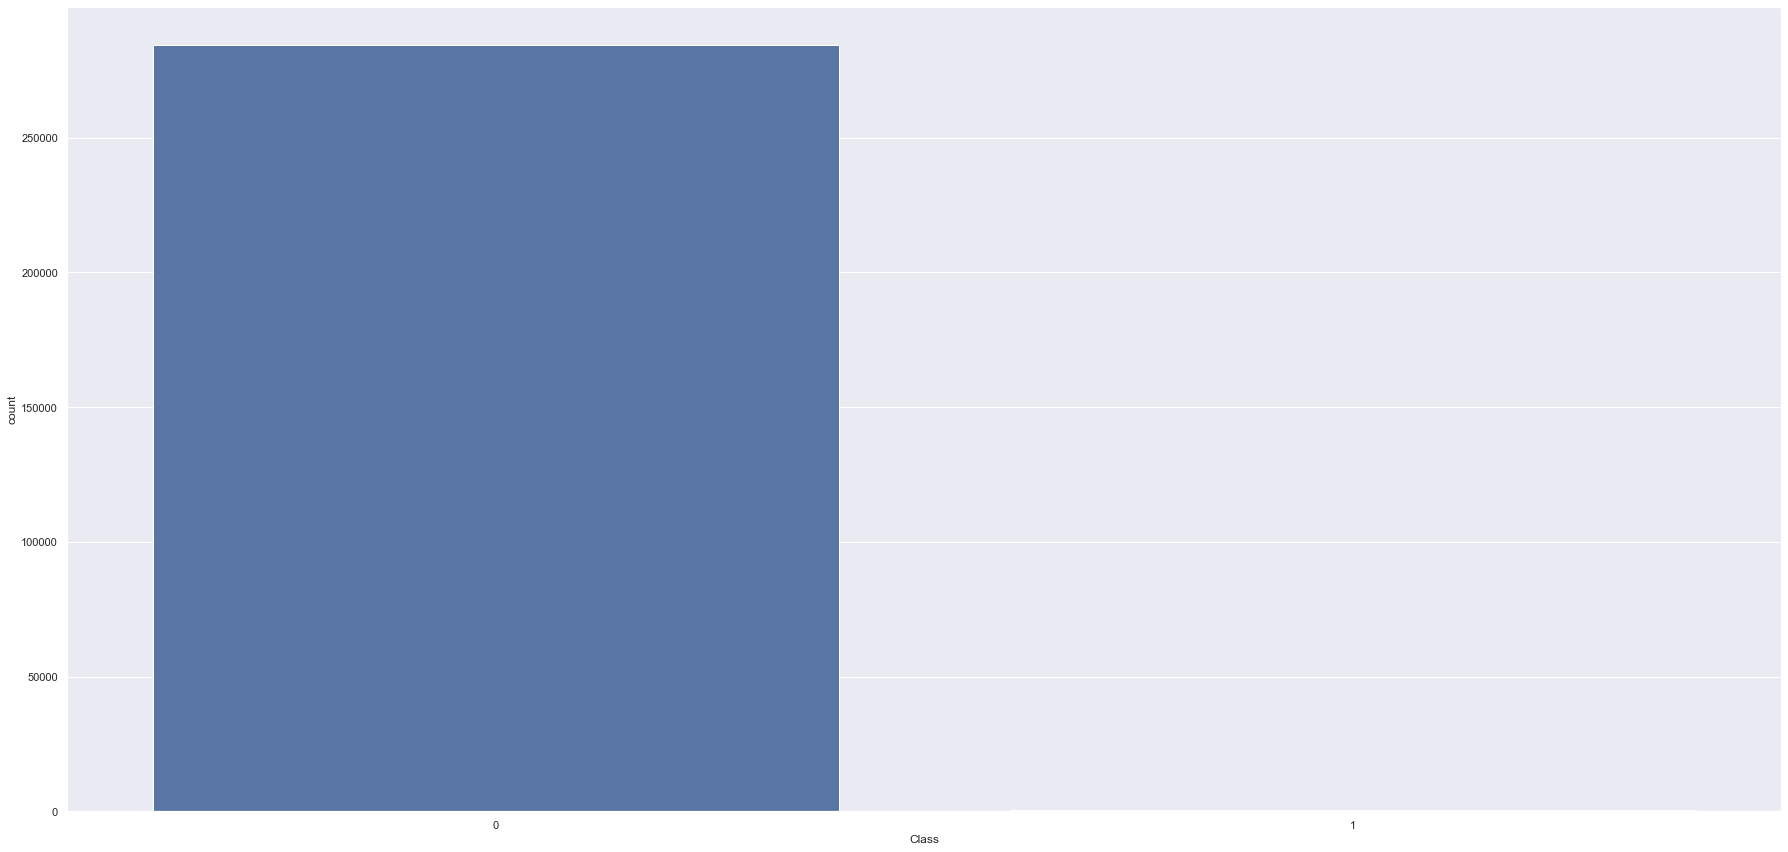

In [16]:
fig, ax = plt.subplots()
sns.countplot( x = df2['Class'], ax=ax )

plt.tight_layout()

In [13]:
df2['Class'].value_counts() / df2.shape[0]

0    0.998273
1    0.001727
Name: Class, dtype: float64

**As you can see, this is an extremely unbalanced dataset, where fraud represents only 0.17% of the total.**

### 2.1.2. Numeric Variables

To visualize the distribution of our numeric variables, we will construct a histogram to see how each feature behaves.

As we can see, some variables, such as "Amount", v25, v28, etc., have some outliers that hinder data visualization. Perhaps, this can be a determining factor as to whether a transaction is fraudulent.

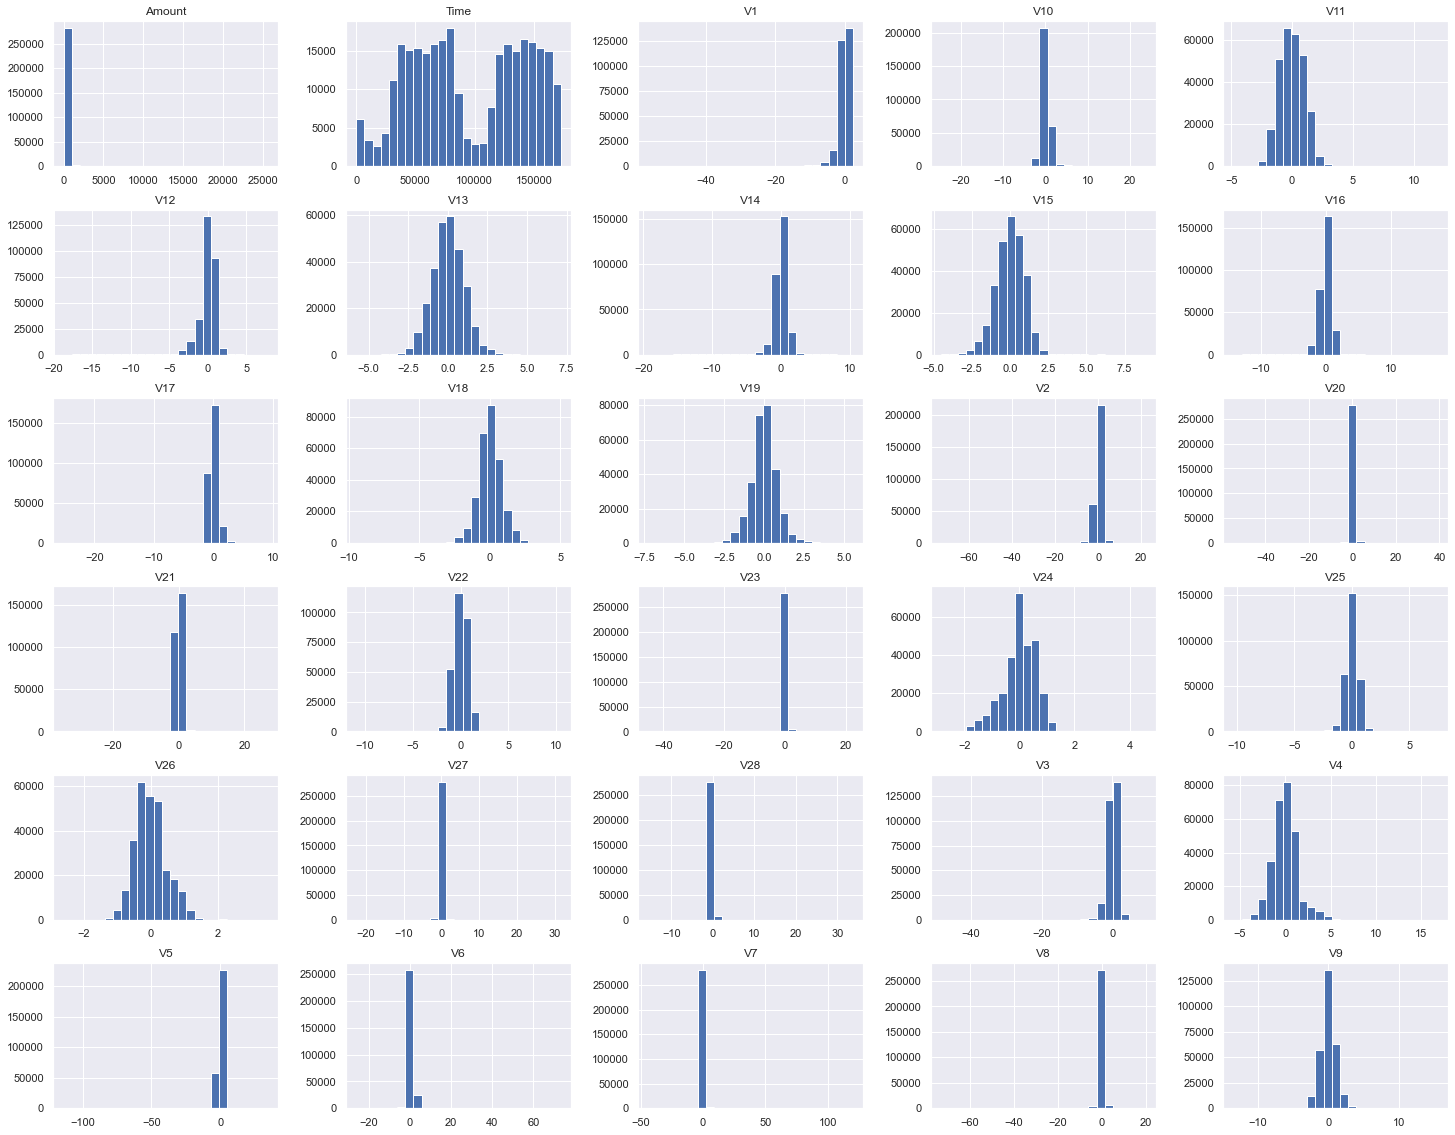

In [21]:
df2.drop( 'Class', axis=1 ).hist( bins=25, figsize=( 25, 20 ) );

## 2.2. Bivariate Analysis

According to [Stephanie Glen](https://www.statisticshowto.com/bivariate-analysis/), bivariate analysis means the analysis of bivariate data. It is one of the simplest forms of statistical analysis, used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

The density graph is very useful to compare the distributions of each variable for each class and see which are the most important for detecting anomalies.

What is looking for in this type of visualization are distributions that differ from one another, allowing for easier identification of fraud. See as an example the variables V3, V4, V10 and V11, as they are very distinct.

On the other hand, variables like V8, V13 and V15 are very similar, showing approximately the same behavior.

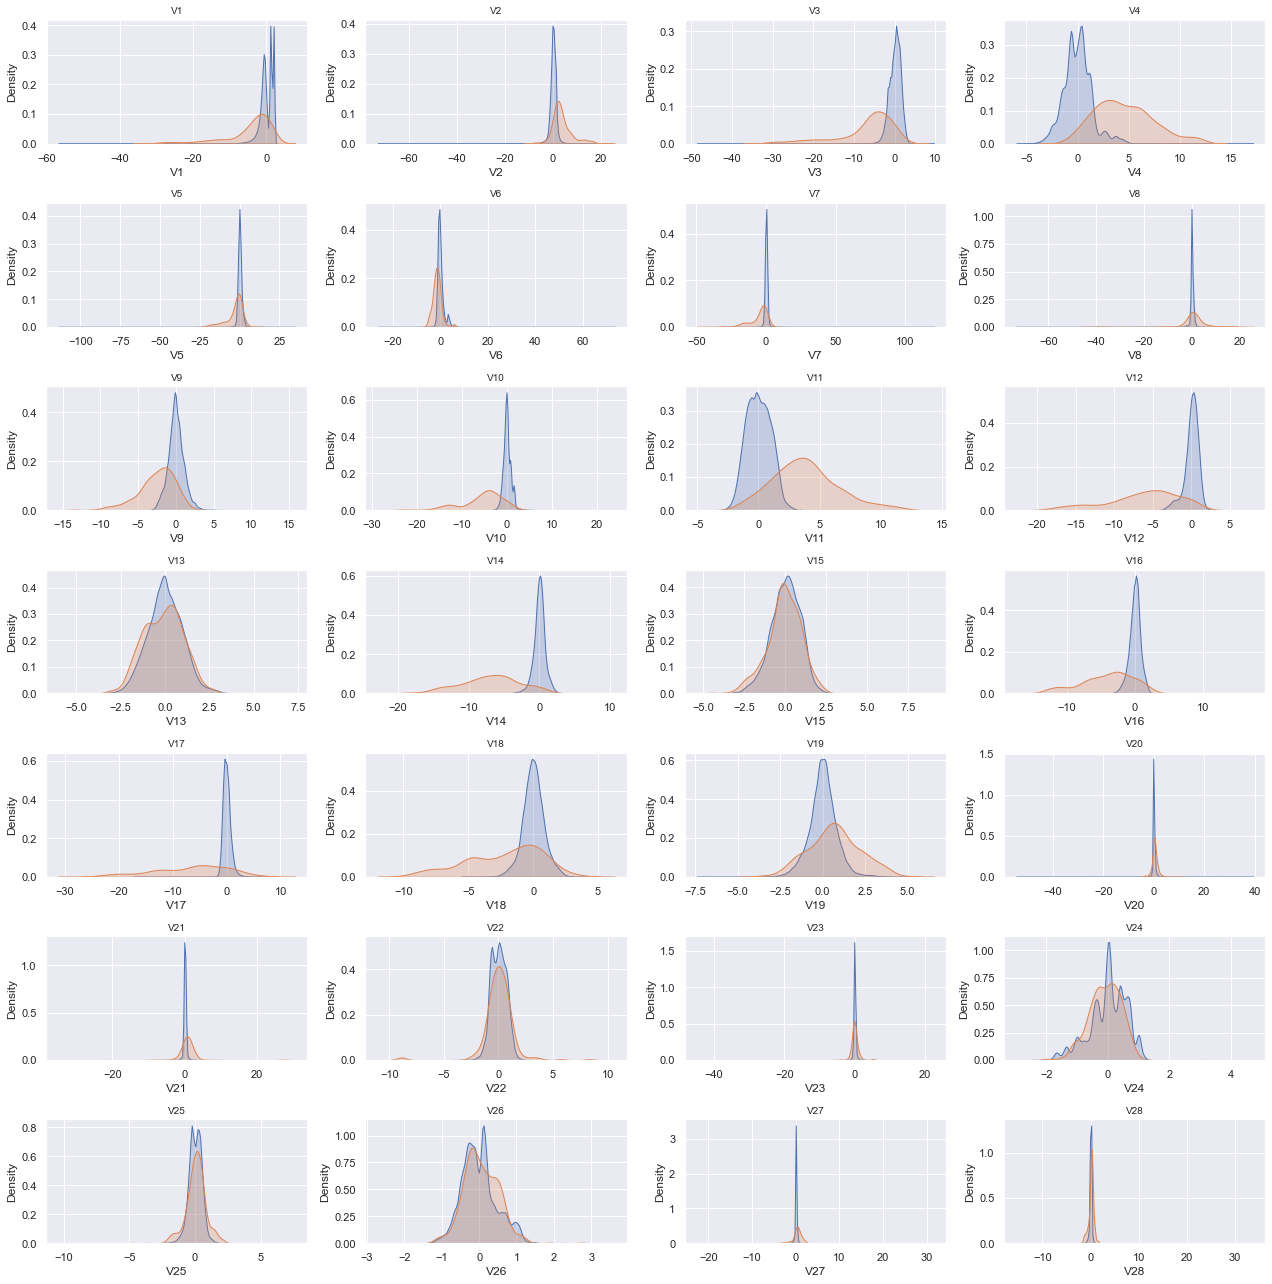

In [7]:
column_names = df2.drop( ['Class', 'Amount', 'Time'], axis=1 ).columns
num_plots = len( column_names )
df_class_0 = df2[df2.Class == 0]
df_class_1 = df2[df2.Class == 1]

fig, ax = plt.subplots( nrows=7, ncols=4, figsize=( 18,18 ) )
fig.subplots_adjust( hspace=1, wspace=1 )

idx = 0
for col in column_names:
    idx += 1
    plt.subplot( 7, 4, idx )
    sns.kdeplot( df_class_0[col], label="Class 0", shade=True )
    sns.kdeplot( df_class_1[col], label="Class 1", shade=True )
    plt.title( col, fontsize=10 )
plt.tight_layout()


We plotted the boxplots to see if there is any difference in the transactions pattern in relation to the Amount dimension.

In general, a different distribution can be seen for the two classes, which will probably contribute to the training of the machine learning model.

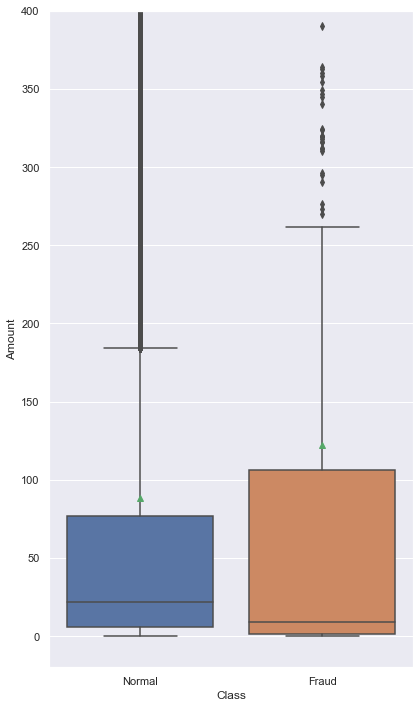

In [33]:
# boxplot
fig, ax = plt.subplots( figsize=(6, 10), sharex=True )

sns.boxplot( x = df2.Class, y = df2.Amount, showmeans=True, ax=ax )
plt.ylim( (-20, 400) )
plt.xticks( [0, 1], ['Normal', 'Fraud'] )

plt.tight_layout()

Two graphs were also plotted in order to compare the distributions of the 2 classes along the time dimension (Time). However, no information was identified from the frequency distributions below.

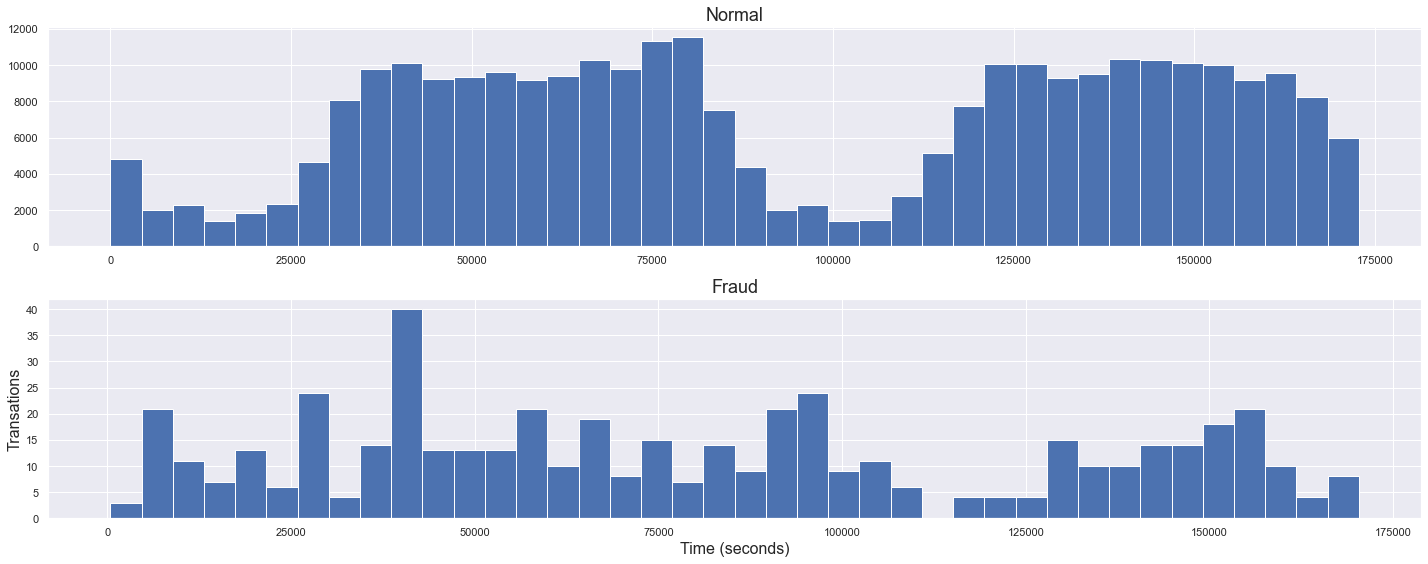

In [30]:
fig, ax = subplots( nrows=2, ncols=1, figsize=(20, 8) )

# class 0
ax[0].set_title( 'Normal', fontsize=18 )
df2.loc[df2['Class'] == 0, 'Time'].hist( bins=40, ax=ax[0] )

# class 1
ax[1].set_title( 'Fraud', fontsize=18 )
df2.loc[df2['Class'] == 1, 'Time'].hist( bins=40, ax=ax[1] )

plt.xlabel( 'Time (seconds)', fontsize=16 )
plt.ylabel( 'Transations', fontsize=16 )
plt.tight_layout()

## 2.3. Multivariate Analysis

According to [Stephanie Glen](https://www.statisticshowto.com/probability-and-statistics/multivariate-analysis/), multivariate analysis is used to study more complex sets of data than what univariate analysis methods can handle. This type of analysis is almost always performed with software (i.e. SPSS or SAS), as working with even the smallest of data sets can be overwhelming by hand.

To do the multivariate analysis, we will use a correlation graph, to analyze which variables are more correlated with the target variable and with other variables.

As we can see, there is no variable that is highly correlated with the target variable. Variables "v7" and "v20" are a little more correlated with variable Amount than the others, but nothing so big that it is relevant to solve our problem.

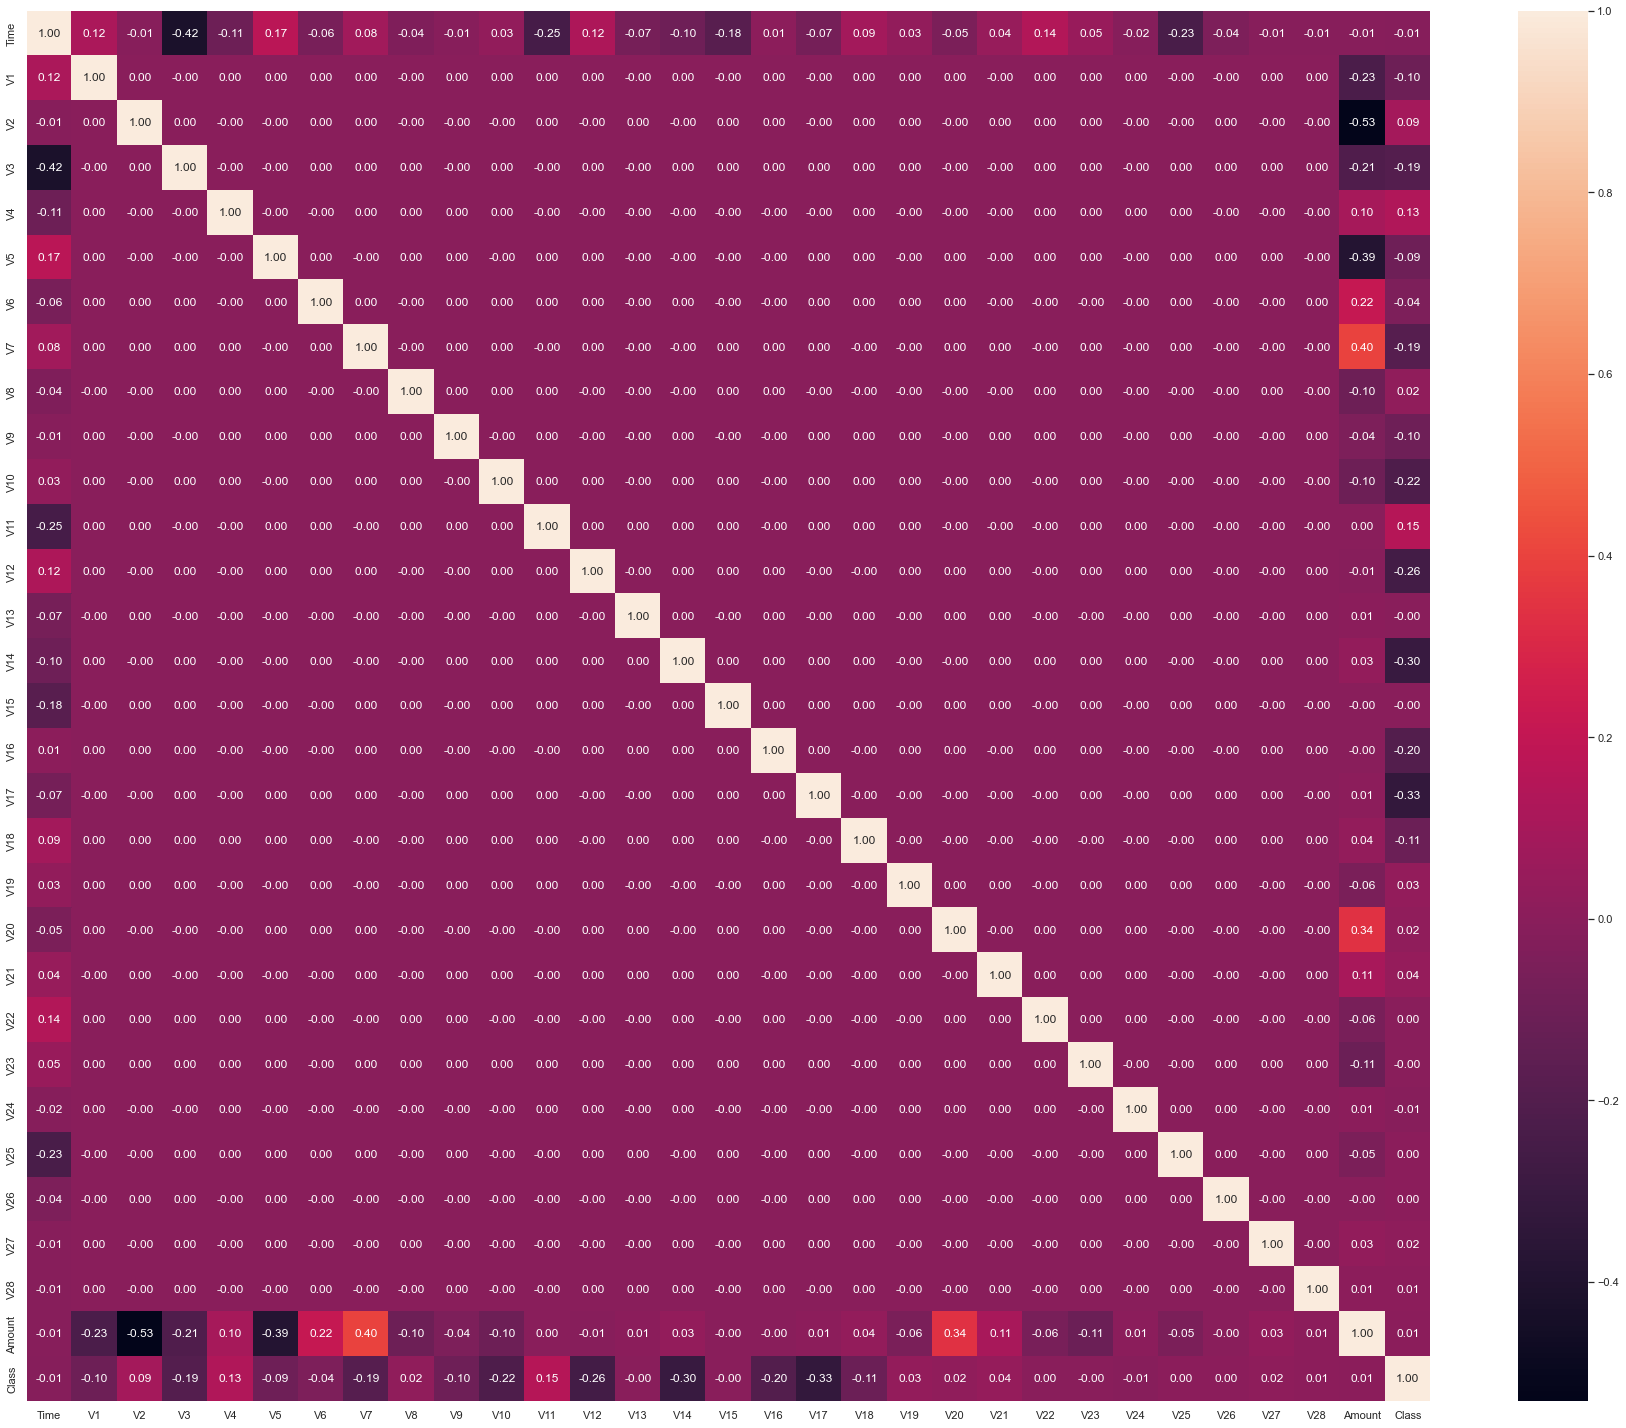

In [77]:
# heat map
plt.figure( figsize=(25, 20) )
sns.heatmap( df2.corr(), annot=True, fmt='.2f' )
plt.tight_layout()

# 3.0. Data Preparation

In [8]:
df3 = df2.copy()

## 3.1. Split dataframe into training and test 

In [8]:
# variables
X = df3.drop( 'Class', axis=1 )

# target
y = df3['Class']

# split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=13 )

## 3.2. Balance dataset

As we saw earlier, our dataset is quite unbalanced in relation to the target variable. Therefore, we will use the undersampling method to balance the data.

**Under-sampling**: reduces dataset imbalance by focusing on the majority class. That is, it randomly eliminates entries from the class with the highest number of occurrences.

1    356
0    356
Name: Class, dtype: int64


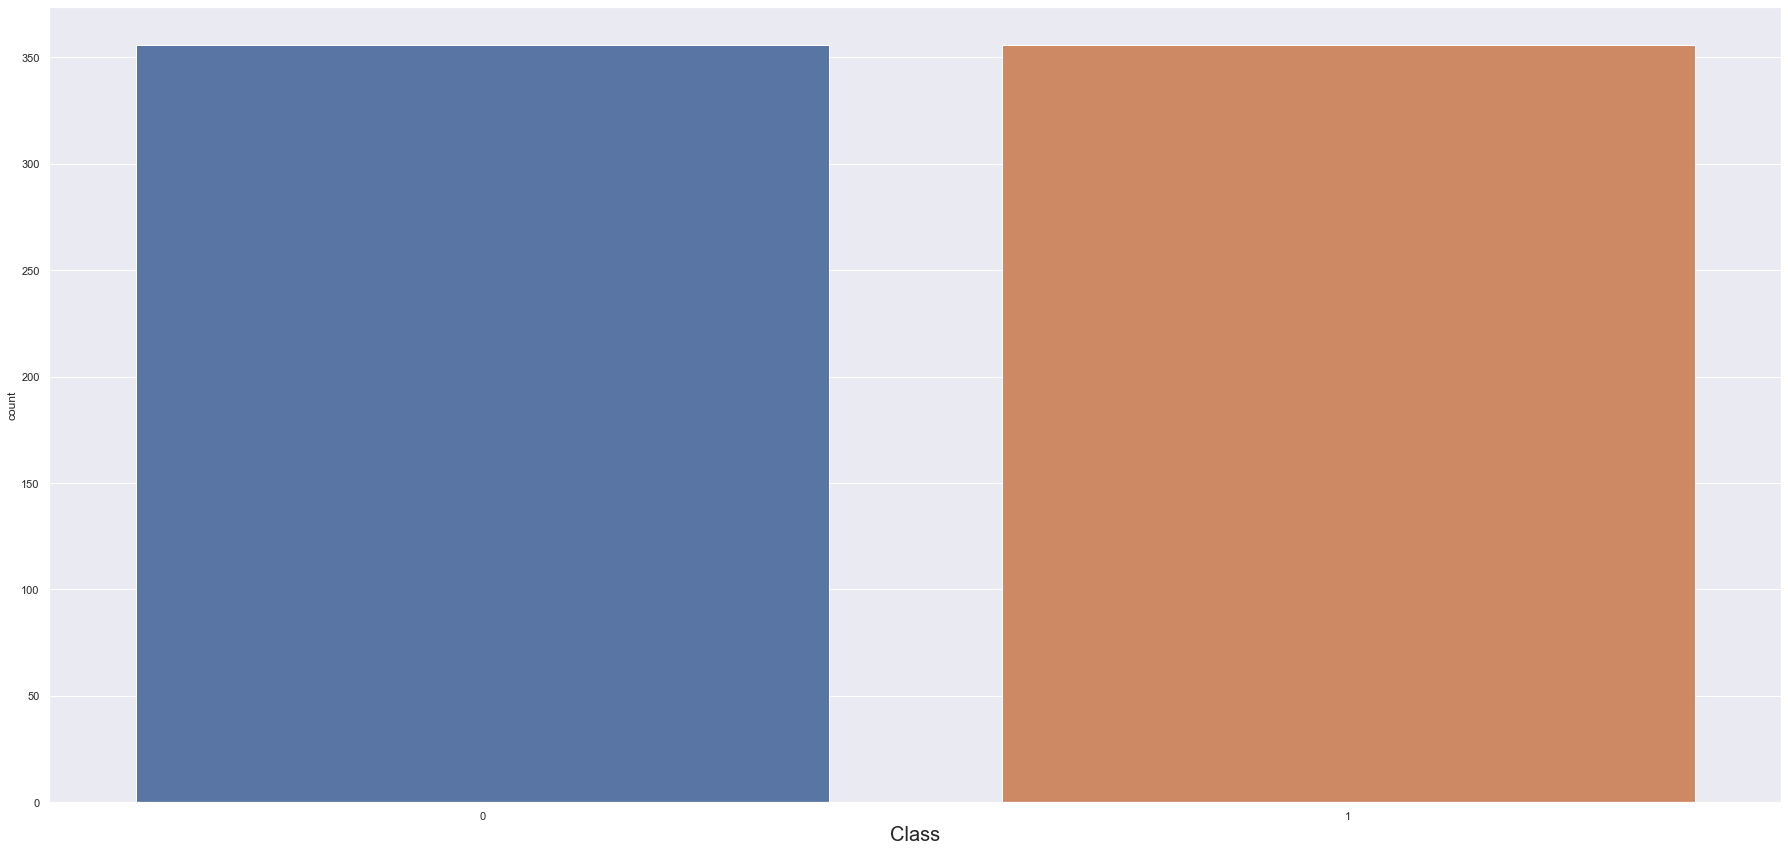

In [9]:
# Under-sampling algorithm
rus = RandomUnderSampler()

# balancing the dataset
X_res, y_res = rus.fit_resample(X_train, y_train)

print( pd.Series( y_res ).value_counts() )

sns.countplot( x=y_res )
plt.xlabel( 'Class', fontsize=20 )

plt.tight_layout()

## 3.3. Rescaling

In order to preserve the dataset outliers, we will use the RobustScaler algorithm to scale the data.

In [10]:
rs = RobustScaler()

# Amount
X_res['Amount'] = rs.fit_transform( X_res['Amount'].values.reshape(-1, 1) )
X_test['Amount'] = rs.transform( X_test['Amount'].values.reshape(-1, 1) )

# Time
X_res['Time'] = rs.fit_transform( X_res['Time'].values.reshape(-1, 1) )
X_test['Time'] = rs.transform( X_test['Time'].values.reshape(-1, 1) )

# 4.0. Machine Learning Modelling

In this section, we will build our predictive models. Therefore, we will use 5 machine learning algorithms, which will be:

- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine
- Naive Bayes

## 4.1. Logistic Regression

              precision    recall  f1-score   support

           0     0.9999    0.9625    0.9809     85307
           1     0.0377    0.9191    0.0723       136

    accuracy                         0.9625     85443
   macro avg     0.5188    0.9408    0.5266     85443
weighted avg     0.9983    0.9625    0.9794     85443

AUC:  0.9408


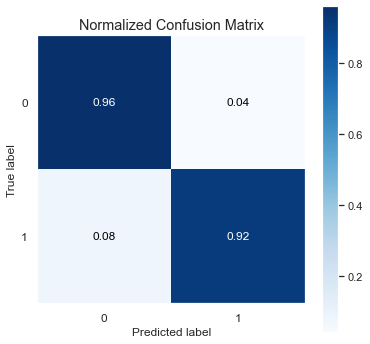

In [38]:
# model
lr = LogisticRegression( random_state = 13 ).fit( X_res, y_res )

# prediction
yhat_lr = lr.predict( X_test )

# performance
model_performance( y_test, yhat_lr )

### 4.1.1. Logistic Regression - Cross Validation

In [13]:
# model
lr = LogisticRegression( random_state = 13 )

# performance
cross_validation( lr, X_res, y_res )

,accuracy,precision,recall,f1,roc
0,0.94+/-0.03,0.96+/-0.02,0.92+/-0.04,0.94+/-0.03,0.97+/-0.01


## 4.2. Decision Tree

              precision    recall  f1-score   support

           0     0.9999    0.8867    0.9399     85307
           1     0.0129    0.9265    0.0254       136

    accuracy                         0.8867     85443
   macro avg     0.5064    0.9066    0.4826     85443
weighted avg     0.9983    0.8867    0.9384     85443

AUC:  0.9066


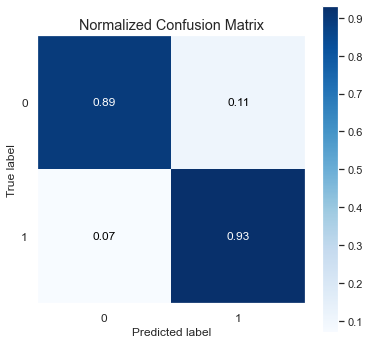

In [16]:
# model
dt = DecisionTreeClassifier( random_state=13 ).fit( X_res, y_res )

# prediction
yhat_dt = dt.predict( X_test )

# performance
model_performance( y_test, yhat_dt )

### 4.2.1. Decision Tree - Cross Validation

In [17]:
# model
dt = DecisionTreeClassifier( random_state=13 )

# performance
cross_validation( dt, X_res, y_res )

,accuracy,precision,recall,f1,roc
0,0.91+/-0.02,0.91+/-0.04,0.91+/-0.03,0.91+/-0.02,0.91+/-0.02


## 4.3. Random Forest

              precision    recall  f1-score   support

           0     0.9997    0.9977    0.9987     85307
           1     0.3684    0.8235    0.5091       136

    accuracy                         0.9975     85443
   macro avg     0.6841    0.9106    0.7539     85443
weighted avg     0.9987    0.9975    0.9980     85443

AUC:  0.9106


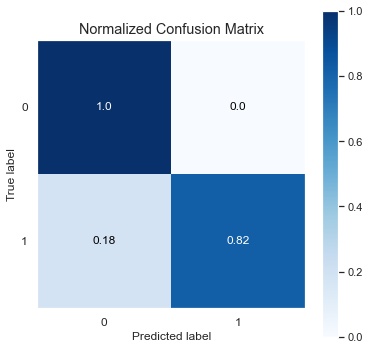

In [19]:
# model
rf = RandomForestClassifier( max_depth=2, random_state=13 ).fit( X_res, y_res )

# prediction
yhat_rf = rf.predict( X_test )

# performance
model_performance( y_test, yhat_rf )

### 4.3.1. Random Forest - Cross Validation

In [20]:
# model
rf = RandomForestClassifier( max_depth=2, random_state=13 )

# performance
cross_validation( rf, X_res, y_res )

,accuracy,precision,recall,f1,roc
0,0.92+/-0.02,1.0+/-0.01,0.85+/-0.04,0.92+/-0.03,0.98+/-0.01


## 4.4. Support Vector Machine

              precision    recall  f1-score   support

           0     0.9999    0.9382    0.9681     85307
           1     0.0233    0.9265    0.0455       136

    accuracy                         0.9382     85443
   macro avg     0.5116    0.9323    0.5068     85443
weighted avg     0.9983    0.9382    0.9666     85443

AUC:  0.9323


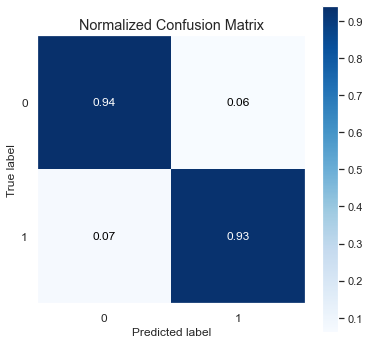

In [22]:
# model
svm = SVC( gamma='auto' ).fit( X_res, y_res )

# prediction
yhat_svm = svm.predict( X_test )

# performance
model_performance( y_test, yhat_svm )

### 4.4. Support Vector Machine - Cross Validation

In [23]:
# model
svm = SVC( gamma='auto' )

# performance
cross_validation( svm, X_res, y_res )

,accuracy,precision,recall,f1,roc
0,0.93+/-0.02,0.94+/-0.04,0.92+/-0.03,0.92+/-0.02,0.97+/-0.01


## 4.5. Naive Bayes

              precision    recall  f1-score   support

           0     0.9998    0.9666    0.9829     85307
           1     0.0392    0.8529    0.0749       136

    accuracy                         0.9665     85443
   macro avg     0.5195    0.9098    0.5289     85443
weighted avg     0.9982    0.9665    0.9815     85443

AUC:  0.9098


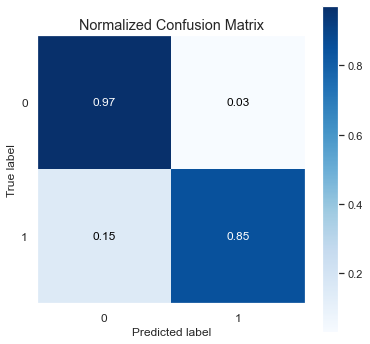

In [25]:
# model
nb = GaussianNB().fit( X_res, y_res )

# prediction
yhat_nb = nb.predict( X_test )

# performance
model_performance( y_test, yhat_nb )

### 4.5.1. Naive Bayes - Cross Validation

In [26]:
# model
nb = GaussianNB()

# performance
cross_validation( nb, X_res, y_res )

,accuracy,precision,recall,f1,roc
0,0.92+/-0.02,0.96+/-0.03,0.87+/-0.04,0.92+/-0.02,0.96+/-0.02


# 5.0. Hyperparameter Fine Tuning

In [13]:
# parameters
parameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]
}

# model
lr = LogisticRegression( random_state=13 )

# Define RandomSearchCV
rs = RandomizedSearchCV( lr, parameters, cv=10, n_iter=15, random_state=13, n_jobs=-1 )

# fit RandomSearchCV
rs.fit( X_res, y_res )

RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=13),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=13)

In [14]:
# The best params to our model
rs.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}

## 5.1. Fit model with the best params - Holdout

              precision    recall  f1-score   support

           0     0.9998    0.9833    0.9915     85307
           1     0.0783    0.8897    0.1440       136

    accuracy                         0.9832     85443
   macro avg     0.5391    0.9365    0.5677     85443
weighted avg     0.9984    0.9832    0.9901     85443

AUC:  0.9365


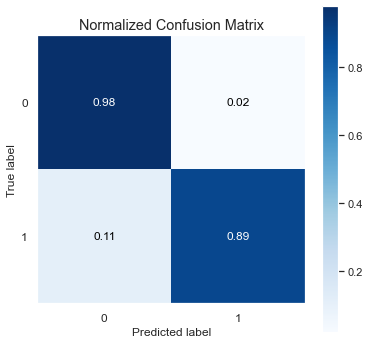

In [15]:
# model
lr = LogisticRegression( solver='newton-cg', penalty='l2', C=0.1, random_state=13 ).fit( X_res, y_res )

# prediction
ypred_lr = lr.predict( X_test )

# performance
model_performance( y_test, ypred_lr )

## 5.2. Fit model with the best params - Cross Validation

In [16]:
# model
lr = LogisticRegression( solver='newton-cg', penalty='l2', C=0.1, random_state=13 )

# performance
cross_validation( lr, X_res, y_res )

,accuracy,precision,recall,f1,roc
0,0.93+/-0.02,0.97+/-0.02,0.89+/-0.05,0.93+/-0.03,0.98+/-0.01


# 6.0. Machine Learning Performance

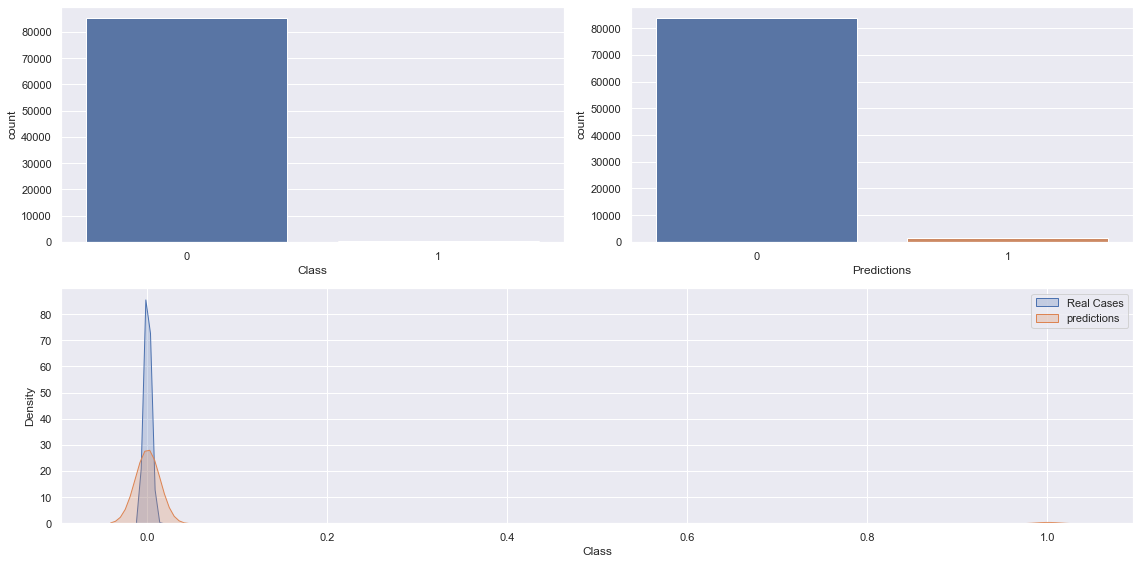

In [19]:
fig = plt.figure( figsize=( 16, 8 ) )
specs = gridspec.GridSpec( ncols=2, nrows=2, figure=fig )

ax1 = fig.add_subplot( specs[0, 0] )
ax2 = fig.add_subplot( specs[0, 1] )
ax3 = fig.add_subplot( specs[1, :] )

sns.countplot( x = y_test, ax=ax1 )
sns.countplot( x = ypred_lr, ax=ax2 )
ax2.set_xlabel( 'Predictions' )

sns.kdeplot( x = y_test, label="Real Cases", shade=True, ax=ax3 )
sns.kdeplot( x = ypred_lr, label="predictions", shade=True, ax=ax3 )
plt.legend()

plt.tight_layout()